# Using DSECS (WIP)

In [2]:
import logging
import datetime as dt
from swarmpal.io import create_paldata, PalDataItem
from swarmpal.toolboxes.secs import processes
import matplotlib.pyplot as plt


### Fetching inputs to the toolbox


In [3]:
def data_params(sc="A"):
    return dict(
        collection=f"SW_OPER_MAG{sc}_LR_1B",
        measurements=["B_NEC"],
        models=["Model = CHAOS"],  # currently must use name "Model"
        auxiliaries=["QDLat"],
        start_time="2016-03-18T11:00:00",
        end_time="2016-03-18T11:50:00",
        server_url="https://vires.services/ows",
        options=dict(asynchronous=False, show_progress=False),
    )


data = create_paldata(
    PalDataItem.from_vires(**data_params("A")),
    PalDataItem.from_vires(**data_params("C")),
)

print(data)


DataTree('paldata', parent=None)
├── DataTree('SW_OPER_MAGA_LR_1B')
│       Dimensions:      (Timestamp: 3000, NEC: 3)
│       Coordinates:
│         * Timestamp    (Timestamp) datetime64[ns] 2016-03-18T11:00:00 ... 2016-03-1...
│         * NEC          (NEC) <U1 'N' 'E' 'C'
│       Data variables:
│           Spacecraft   (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A' 'A'
│           B_NEC        (Timestamp, NEC) float64 1.413e+04 -1.228e+03 ... 4.675e+04
│           Latitude     (Timestamp) float64 -82.61 -82.55 -82.49 ... 70.61 70.55 70.48
│           QDLat        (Timestamp) float64 -68.58 -68.54 -68.5 ... 65.61 65.55 65.48
│           B_NEC_Model  (Timestamp, NEC) float64 1.411e+04 -1.231e+03 ... 4.676e+04
│           Radius       (Timestamp) float64 6.832e+06 6.832e+06 ... 6.815e+06 6.815e+06
│           Longitude    (Timestamp) float64 -26.01 -25.83 -25.66 ... 154.8 154.8 154.8
│       Attributes:
│           Sources:         ['CHAOS-7_static.shc', 'SW_OPER_MAGA_LR_1

## Applying the DSECS process

In [4]:
process = processes.DSECS_Process(
    config={
        "dataset_alpha": "SW_OPER_MAGA_LR_1B",
        "dataset_charlie": "SW_OPER_MAGC_LR_1B",
    },
)
data = data.swarmpal.apply(process)

/home/kakis/projects/SwarmX/src/swarmpal/toolboxes/secs/dsecs_algorithms.py:1674: UserWarning: Discarding nonzero nanoseconds in conversion.
  self.exclusionmax, self.exclusionmin = get_exclusion_zone(SwA, SwC)


<xarray.Dataset>
Dimensions:        (Timestamp: 3000, NEC: 3)
Coordinates:
  * Timestamp      (Timestamp) datetime64[ns] 2016-03-18T11:00:00 ... 2016-03...
  * NEC            (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft     (Timestamp) object 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    B_NEC          (Timestamp, NEC) float64 1.413e+04 -1.228e+03 ... 4.675e+04
    Latitude       (Timestamp) float64 -82.61 -82.55 -82.49 ... 70.55 70.48
    QDLat          (Timestamp) float64 -68.58 -68.54 -68.5 ... 65.61 65.55 65.48
    B_NEC_Model    (Timestamp, NEC) float64 1.411e+04 -1.231e+03 ... 4.676e+04
    Radius         (Timestamp) float64 6.832e+06 6.832e+06 ... 6.815e+06
    Longitude      (Timestamp) float64 -26.01 -25.83 -25.66 ... 154.8 154.8
    ApexLatitude   (Timestamp) float64 -69.37 -69.33 -69.29 ... 66.43 66.36
    ApexLongitude  (Timestamp) float64 25.92 26.02 26.12 ... -140.5 -140.4
Attributes:
    Sources:         ['CHAOS-7_static.shc', 'SW_OPER_MAGA_LR_1B_20160318T0000...
 

# Plotting the outputs and fitted magnetic field 

## Simple line plots of the currents from the central latitudinal slice
The outputs in the datatree are enumerated, for each analyzed equatorial crossing included inside the timestamps. (output_0,output_1 etc.) 

Coordinates:
    Longitude  (x, y) float64 348.4 349.1 349.8 350.6 ... 350.5 351.2 351.9
    Latitude   (x, y) float64 -39.96 -39.96 -39.96 -39.96 ... 39.54 39.54 39.54


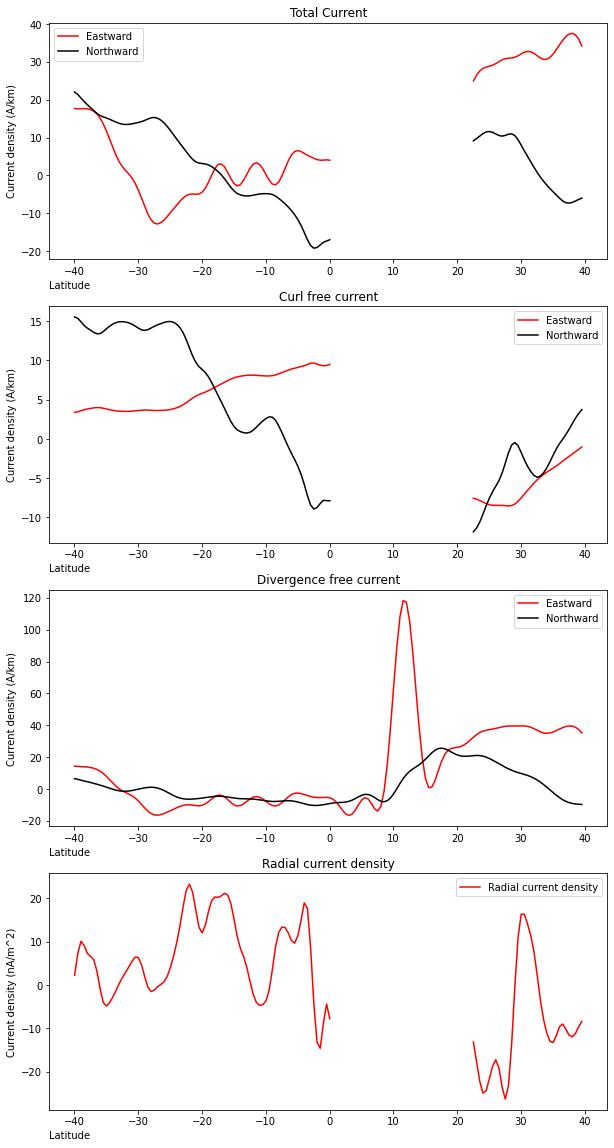

In [ ]:
print(data['output_0'].coords)
print(data['output_0'].data_vars)

latitudes = data['output_0']['Latitude'][:,3]
fig,ax = plt.subplots(4,1,figsize=(10,20))
lineE= ax[0].plot(latitudes, data['output_0']['JEastTotal'][:,3],'r',label='Eastward')
lineN =ax[0].plot(latitudes, data['output_0']['JNorthTotal'][:,3],'k',label='Northward')
ax[0].set_title('Total Current')
ax[0].set_ylabel('Current density (A/km)')




lineE= ax[1].plot(latitudes, data['output_0']['JEastCf'][:,3],'r',label='Eastward')
lineN =ax[1].plot(latitudes, data['output_0']['JNorthCf'][:,3],'k',label='Northward')
ax[1].set_title('Curl free current')
ax[1].set_ylabel('Current density (A/km)')

#ax[0].set_title('Total Current (DF + CF)')

lineE= ax[2].plot(latitudes, data['output_0']['JEastDf'][:,3],'r',label='Eastward')
lineN =ax[2].plot(latitudes, data['output_0']['JNorthDf'][:,3],'k',label='Northward')
ax[2].set_title('Divergence free current')
ax[2].set_ylabel('Current density (A/km)')

liner= ax[3].plot(latitudes, data['output_0']['Jr'][:,3],'r',label='Radial current density')
ax[3].set_title('Radial current density')
ax[3].set_ylabel('Current density (nA/m^2)')

for axv in ax:
    axv.set_xlabel('Latitude',loc='left')
    axv.legend() 

